In [1]:
#This notebook trains the conv1D model for dataset8
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.utils import Sequence
from keras.layers import Conv2D, MaxPooling2D
from qkeras import *

from keras.utils import Sequence
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from loss import custom_loss

import os
import random

pi = 3.14159265359

maxval=1e9
minval=1e-9

2025-05-09 19:34:10.571715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 19:34:10.571775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 19:34:10.573492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 19:34:10.582550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-09 19:34:14.231982: W tensorflow/compiler/tf2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#from dataprep import *
from OptimizedDataGenerator import OptimizedDataGenerator
import tensorflow_probability as tfp


2025-05-09 19:34:17.333753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38397 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 7g.40gb, pci bus id: 0000:81:00.0, compute capability: 8.0


In [4]:
batch_size = 5000
val_batch_size = 5000
train_file_size = 50  
val_file_size = 10

dataset_base_dir = f'/depot/cms/users/das214/dataset8/unflipped/'
tfrecords_base_dir = os.path.expanduser("~/TFrecords/")
os.makedirs(tfrecords_base_dir, exist_ok=True)

data_directory_path = os.path.join(dataset_base_dir, 'recon3D/')
labels_directory_path = os.path.join(dataset_base_dir, 'labels/')

tfrecords_dir_train = os.path.join(tfrecords_base_dir, 'TFR_train')
tfrecords_dir_validation = os.path.join(tfrecords_base_dir, 'TFR_val')

print("Nuevo directorio para train:", tfrecords_dir_train)
print("Nuevo directorio para validation:", tfrecords_dir_validation)

# validation_generator = OptimizedDataGenerator(
#      data_directory_path = data_directory_path,
#      labels_directory_path = labels_directory_path,
#      is_directory_recursive = False,
#      file_type = "parquet",
#      data_format = "3D",
#      batch_size = val_batch_size,
#      file_count = val_file_size,
#      to_standardize= True,
#      include_y_local= False, 
#      labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
#      input_shape = (2,13,21), # (20,13,21),
#      transpose = (0,2,3,1),
#      shuffle = False, 
#      files_from_end=True,
#      tfrecords_dir = tfrecords_dir_validation,
#      use_time_stamps = [0, 19], #-1
#      max_workers = 1 # Don't make this too large (will use up all RAM)
#  )

# training_generator = OptimizedDataGenerator(
#      data_directory_path = data_directory_path,
#      labels_directory_path = labels_directory_path,
#      is_directory_recursive = False,
#      file_type = "parquet",
#      data_format = "3D",
#      batch_size = batch_size,
#      file_count = train_file_size,
#      to_standardize= True,
#      include_y_local= False,
#      labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
#      input_shape = (2,13,21), # (20,13,21),
#      transpose = (0,2,3,1),
#      shuffle = False, # True 

#      tfrecords_dir = tfrecords_dir_train,
#      use_time_stamps = [0, 19], #-1
#      max_workers = 1 # Don't make this too large (will use up all RAM)
#  )

training_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_train,
    shuffle = True,
    seed = 13,
    quantize = True
)

validation_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_validation,
    shuffle = True,
    seed = 13,
    quantize = True
)

Nuevo directorio para train: /home/callea/TFrecords/TFR_train
Nuevo directorio para validation: /home/callea/TFrecords/TFR_val


In [5]:
print(len(os.listdir(data_directory_path)))
print(len(os.listdir(labels_directory_path)))

160
160


In [6]:
path_1 = os.listdir(data_directory_path)[0]
path_1 = os.path.join(data_directory_path, path_1)

import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_parquet(path_1)

In [7]:
x = df1.iloc[0]

data_files_path_list = os.listdir(data_directory_path)
labels_files_path_list = os.listdir(labels_directory_path)

data_df = pd.read_parquet(os.path.join(data_directory_path, data_files_path_list[0])) 
labels_df = pd.read_parquet(os.path.join(labels_directory_path, labels_files_path_list[0]))

In [8]:
len(df1)

49999

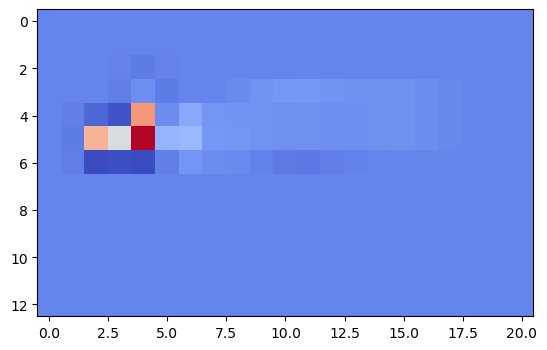

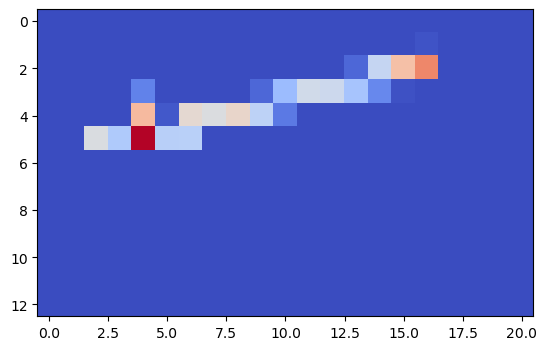

In [9]:
reshaped_data = x.values.reshape(20, 13, 21)

plt.imshow(reshaped_data[0,:,:], cmap='coolwarm') # first time-step
plt.show()
plt.imshow(reshaped_data[-1,:,:], cmap='coolwarm') # Last time-step
plt.show()

In [10]:
reshaped_data[0,:,:]

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.3600e+01, -1.0760e+02,
        -1.7900e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -7.0800e+01

In [11]:
import keras
from keras.layers import *
from keras.models import Sequential, Model
from keras.utils import Sequence
from qkeras import *

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

def var_network(var, hidden=10, output=2):
    var = Flatten(name="flatten")(var)
    var = QDense(
        hidden,
        kernel_quantizer=quantized_bits(8, 0, alpha=1),
        bias_quantizer=quantized_bits(8, 0, alpha=1),
        kernel_regularizer=tf.keras.regularizers.L1L2(0.01),
        activity_regularizer=tf.keras.regularizers.L2(0.01),
        name="dense_1"
    )(var)
    #var = keras.activations.tanh(var)
    var = QActivation("quantized_tanh(8, 0, 1)", name="activation_tanh_2")(var)
    var = QDense(
        hidden,
        kernel_quantizer=quantized_bits(8, 0, alpha=1),
        bias_quantizer=quantized_bits(8, 0, alpha=1),
        kernel_regularizer=tf.keras.regularizers.L1L2(0.01),
        activity_regularizer=tf.keras.regularizers.L2(0.01),
        name="dense_2"
    )(var)
    #var = keras.activations.tanh(var)
    var = QActivation("quantized_tanh(8, 0, 1)", name="activation_tanh_3")(var)
    return QDense(
        output,
        kernel_quantizer=quantized_bits(8, 0, alpha=1),
        bias_quantizer=quantized_bits(8, 0, alpha=1),
        kernel_regularizer=tf.keras.regularizers.L1L2(0.01),
        name="dense_3"
    )(var)

def conv_network(var, kernel_size=3):
    nrows = var.shape[1] # 13, for now
    ncols = var.shape[2] # 20, for now
    timeslices = var.shape[3] # either 20 or 2, for now
    proj_x = AveragePooling2D(
        pool_size=(1, 21),
        strides=None,
        padding="valid",
        data_format=None,
        name="avg_pooling_2d_proj_x"
    )(var)
    proj_x = Reshape((nrows, timeslices), name="reshape_proj_x")(proj_x)
    proj_y = AveragePooling2D(
        pool_size=(nrows, 1),
        strides=None,
        padding="valid",
        data_format=None,
        name="avg_pooling_2d_proj_y"
    )(var)
    proj_y = Reshape((ncols, timeslices), name="reshape_proj_y")(proj_y)

    proj_x = QConv1D(
        5,kernel_size,
        kernel_quantizer=quantized_bits(4, 0, 1, alpha=1),
        bias_quantizer=quantized_bits(4, 0, 1, alpha=1),
        kernel_regularizer=tf.keras.regularizers.L1L2(0.01),
        bias_regularizer=tf.keras.regularizers.L1L2(0.01),
        activity_regularizer=tf.keras.regularizers.L2(0.01),
        name="conv1d_proj_x"
    )(proj_x)

    proj_y = QConv1D(
        5,kernel_size,
        kernel_quantizer=quantized_bits(4, 0, 1, alpha=1),
        bias_quantizer=quantized_bits(4, 0, 1, alpha=1),
        #bias_quantizer=quantized_bits(4, 0, alpha=1),
        #depthwise_regularizer=tf.keras.regularizers.L1L2(0.01),
        #pointwise_regularizer=tf.keras.regularizers.L1L2(0.01),
        kernel_regularizer=tf.keras.regularizers.L1L2(0.01),
        bias_regularizer=tf.keras.regularizers.L1L2(0.01),
        activity_regularizer=tf.keras.regularizers.L2(0.01),
        name="conv1d_proj_y"
    )(proj_y)

    var = Concatenate(axis=1, name="concatenate")([proj_x, proj_y])

    #var = keras.activations.tanh(var)
    var = QActivation("quantized_tanh(4, 0, 1)", name="activation_tanh_1")(var)

    return var

def CreateModel(shape):
    x_base = x_in = Input(shape, name="input_pxls/")
    stack = conv_network(x_base)
    #stack = AveragePooling2D(
    #    pool_size=(2, 2),
    #    strides=None,
    #    padding="valid",
    #    data_format=None,
    #)(stack)
    #stack = QActivation("quantized_bits(8, 0, alpha=1)")(stack)
    stack = var_network(stack, hidden=16, output=14)
    model = Model(inputs=x_in, outputs=stack, name="smrtpxl_regression")
    return model

In [12]:
# compiles model
model = CreateModel((13,21,2))
model.summary()

2025-05-09 19:34:23.178481: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "smrtpxl_regression"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_pxls/ (InputLayer)    [(None, 13, 21, 2)]          0         []                            
                                                                                                  
 avg_pooling_2d_proj_x (Ave  (None, 13, 1, 2)             0         ['input_pxls/[0][0]']         
 ragePooling2D)                                                                                   
                                                                                                  
 avg_pooling_2d_proj_y (Ave  (None, 1, 21, 2)             0         ['input_pxls/[0][0]']         
 ragePooling2D)                                                                                   
                                                                                 

In [13]:
def custom_loss(y, p_base, minval=1e-9, maxval=1e9, scale = 512):
    
    p = p_base
    
    mu = p[:, 0:8:2]
    
    # creating each matrix element in 4x4
    Mdia = minval + tf.math.maximum(p[:, 1:8:2], 0.0)
    Mcov = p[:,8:]
    
    # placeholder zero element
    zeros = tf.zeros_like(Mdia[:,0])
    
    # assembles scale_tril matrix
    row1 = tf.stack([Mdia[:,0],zeros,zeros,zeros])
    row2 = tf.stack([Mcov[:,0],Mdia[:,1],zeros,zeros])
    row3 = tf.stack([Mcov[:,1],Mcov[:,2],Mdia[:,2],zeros])
    row4 = tf.stack([Mcov[:,3],Mcov[:,4],Mcov[:,5],Mdia[:,3]])

    scale_tril = tf.transpose(tf.stack([row1,row2,row3,row4]),perm=[2,0,1])

    dist = tfp.distributions.MultivariateNormalTriL(loc = mu, scale_tril = scale_tril) 
    
    likelihood = dist.prob(y)  
    likelihood = tf.clip_by_value(likelihood,minval,maxval)

    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL)

In [14]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss=custom_loss)

In [15]:
fingerprint = '%08x' % random.randrange(16**8)
os.makedirs("trained_models", exist_ok=True)
base_dir = f'./trained_models/model-{fingerprint}-checkpoints'
os.makedirs(base_dir, exist_ok=True)  
checkpoint_filepath = base_dir + '/weights.{epoch:02d}-t{loss:.2f}-v{val_loss:.2f}.hdf5'

In [16]:
print(fingerprint)

38dee53f


In [17]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, Callback
from utils import get_loss_metrics, reset_loss_trackers
import csv

early_stopping_patience = 50

class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        checkpoints = [f for f in os.listdir(base_dir) if f.startswith('weights')]
        if len(checkpoints) > 1:
            checkpoints.sort()
            for checkpoint in checkpoints[:-1]:
                os.remove(os.path.join(base_dir, checkpoint))

es = EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

mcp = CustomModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

csv_logger = CSVLogger(f'{base_dir}/training_log.csv', append=True)

In [18]:
history = model.fit(
        x=training_generator,
        validation_data=validation_generator,
        callbacks=[es, mcp, csv_logger],
        epochs=1000,
        shuffle=False,
        steps_per_epoch=len(training_generator),
        validation_steps=len(validation_generator),
        verbose=1
    )

Epoch 1/1000


2025-05-09 19:34:27.861198: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-05-09 19:34:27.963500: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-05-09 19:34:28.200869: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55e8bbfd4b50
2025-05-09 19:34:29.461028: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcaf440a360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-09 19:34:29.461084: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 7g.40gb, Compute Capability 8.0
2025-05-09 19:34:29.467664: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746812069.590471 1076119 device_compiler.h:186] Compile

499/499 [==============================] - ETA: 0s - loss: 7555.0229
Epoch 1: val_loss improved from inf to -4031.90625, saving model to ./trained_models/model-38dee53f-checkpoints/weights.01-t7555.02-v-4031.91.hdf5
499/499 [==============================] - 64s 120ms/step - loss: 7555.0229 - val_loss: -4031.9062
Epoch 2/1000
499/499 [==============================] - ETA: 0s - loss: -6463.2031
Epoch 2: val_loss improved from -4031.90625 to -7332.52295, saving model to ./trained_models/model-38dee53f-checkpoints/weights.02-t-6463.20-v-7332.52.hdf5
499/499 [==============================] - 56s 111ms/step - loss: -6463.2031 - val_loss: -7332.5229
Epoch 3/1000
499/499 [==============================] - ETA: 0s - loss: -8052.3452
Epoch 3: val_loss improved from -7332.52295 to -8369.87109, saving model to ./trained_models/model-38dee53f-checkpoints/weights.03-t-8052.35-v-8369.87.hdf5
499/499 [==============================] - 51s 102ms/step - loss: -8052.3452 - val_loss: -8369.8711
Epoch 4

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



499/499 [==============================] - ETA: 0s - loss: -19655.6172
Epoch 263: val_loss did not improve from -19836.00586
499/499 [==============================] - 42s 85ms/step - loss: -19655.6172 - val_loss: -19495.4668
Epoch 264/1000
499/499 [==============================] - ETA: 0s - loss: -19615.3281
Epoch 264: val_loss did not improve from -19836.00586
499/499 [==============================] - 42s 84ms/step - loss: -19615.3281 - val_loss: -19684.7637
Epoch 265/1000
499/499 [==============================] - ETA: 0s - loss: -19679.9570
Epoch 265: val_loss did not improve from -19836.00586
499/499 [==============================] - 42s 85ms/step - loss: -19679.9570 - val_loss: -19624.4297
Epoch 266/1000
499/499 [==============================] - ETA: 0s - loss: -19643.0605
Epoch 266: val_loss did not improve from -19836.00586
499/499 [==============================] - 56s 113ms/step - loss: -19643.0605 - val_loss: -19408.2871
Epoch 267/1000
499/499 [==========================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

